# 综合大作业

**第一步：爱奇艺《青春有你2》评论数据爬取**(参考链接：[https://www.iqiyi.com/v_19ryfkiv8w.html#curid=15068699100_9f9bab7e0d1e30c494622af777f4ba39](https://www.iqiyi.com/v_19ryfkiv8w.html#curid=15068699100_9f9bab7e0d1e30c494622af777f4ba39))
* 爬取任意一期正片视频下评论
* 评论条数不少于1000条

**第二步：词频统计并可视化展示**
* 数据预处理：清理清洗评论中特殊字符（如：@#￥%、emoji表情符）,清洗后结果存储为txt文档
* 中文分词：添加新增词（如：青你、奥利给、冲鸭），去除停用词（如：哦、因此、不然、也好、但是）
* 统计top10高频词
* 可视化展示高频词

**第三步：绘制词云**
* 根据词频生成词云
* 可选项-添加背景图片，根据背景图片轮廓生成词云 

**第四步：结合PaddleHub，对评论进行内容审核**


# 需要的配置和准备
* 中文分词需要jieba
* 词云绘制需要wordcloud
* 可视化展示中需要的中文字体
* 网上公开资源中找一个中文停用词表
* 根据分词结果自己制作新增词表
* 准备一张词云背景图（附加项，不做要求，可用hub抠图实现）
* paddlehub配置



In [12]:
!pip install jieba
!pip install wordcloud

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
     |████████████████████████████████| 368kB 11.1MB/s eta 0:00:01


In [11]:
# Linux系统默认字体文件路径
!ls /usr/share/fonts/
# 查看系统可用的ttf格式中文字体
!fc-list :lang=zh | grep ".ttf"

cmap  truetype	type1  X11
/home/aistudio/.fonts/simhei.ttf: SimHei,黑体:style=Regular,Normal,obyčejné,Standard,Κανονικά,Normaali,Normál,Normale,Standaard,Normalny,Обычный,Normálne,Navadno,Arrunta


In [5]:
# !wget https://mydueros.cdn.bcebos.com/font/simhei.ttf # 下载中文字体
# #创建字体目录fonts
!mkdir .fonts
# # 复制字体文件到该路径
!cp fonts/simhei.ttf .fonts/

In [6]:
#安装模型
!hub install porn_detection_lstm==1.1.0
!pip install --upgrade paddlehub

The version of PaddlePaddle or PaddleHub can not match module, please upgrade your PaddlePaddle or PaddleHub according to the form below.
+--------------------------------+----------+------------------+------------------+
|          ResourceName          | Version  |   PaddlePaddle   |    PaddleHub     |
+--------------------------------+----------+------------------+------------------+
|      porn_detection_lstm       |  1.1.0   |      >1.6.2      |      >1.6.0      |
+--------------------------------+----------+------------------+------------------+
|      porn_detection_lstm       |  1.0.0   |        -         |        -         |
+--------------------------------+----------+------------------+------------------+

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
Requirement already up-to-date: paddlehub in /opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages (1.5.0)


In [10]:
from __future__ import print_function
import requests
import json
import re #正则匹配
import time #时间处理模块
import jieba #中文分词
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from PIL import Image
from wordcloud import WordCloud  #绘制词云模块
import paddlehub as hub

ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
#请求爱奇艺评论接口，返回response信息
def getMovieinfo(url):
    '''
    请求爱奇艺评论接口，返回response信息
    参数  url: 评论的url
    :return: response信息
    '''
    session = requests.session()    #实例化session 会话保持
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.122 Safari/537.36'}
    response = session.get(url,headers=headers)
    if response.status_code==200:
        return response.text


#解析json数据，获取评论
def saveMovieInfoToFile(lastId,arr):
    '''
    解析json数据，获取评论
    参数  lastId:最后一条评论ID  arr:存放文本的list
    :return: 新的lastId
    '''
    url ="https://sns-comment.iqiyi.com/v3/comment/get_comments.action?agent_type=118&agent_version=9.11.5&business_type=17&content_id=15068699100&page=&page_size=10&types=time&last_id="
    url += str(lastId)
    responesJson = json.loads(getMovieinfo(url))
    comments = responesJson['data']['comments']
    for val in comments:
        if 'content' in val.keys():
            # print(val['content'])
            arr.append(val['content'])
        lastId = str(val['id'])
    return lastId

In [7]:
#去除文本中特殊字符
def clear_special_char(content):
    '''
    正则处理特殊字符
    参数 content:原文本
    return: 清除后的文本
    '''
    s = re.sub(r"</?(.+?)>|&nbsp;|\t|\r","",content)
    s = re.sub(r"\n","",s)
    s = re.sub(r"\*","\\*",s)
    s = re.sub("[^\u4e00-\u9fa5^a-z^A-Z^0-9]","",s)
    s = re.sub("[\001\002\003\004\005\006\007\x08\x09\x0a\x0b\x0c\x0d\x0e\x0f\x10\x11\x12\x13\x14\x15\x16\x17\x18\x19\x1a]+","", s)
    s = re.sub("[a-zA-Z]","",s)
    s = re.sub("^d+(\.\d+)?$","",s)

    return s

In [8]:
def fenci(text):
    '''
    利用jieba进行分词
    参数 text:需要分词的句子或文本
    return：分词结果
    '''
    jieba.load_userdict('jieba.txt')
    seg = jieba.lcut(text, cut_all=False)
    return seg

In [9]:
def stopwordslist(file_path):
    '''
    创建停用词表
    参数 file_path:停用词文本路径
    return：停用词list
    '''
    stopwords = [line.strip() for line in open(file_path, encoding='UTF-8').readlines()]
    return stopwords

In [10]:
def movestopwords(sentence,stopwords,counts):
    '''
    去除停用词,统计词频
    参数 file_path:停用词文本路径 stopwords:停用词list counts: 词频统计结果
    return：None
    '''
    out = []
    for word in sentence:
        if word not in stopwords:
            if len(word) != 1:
                counts[word] = counts.get(word,0) + 1
    return None
    

In [11]:
def drawcounts(counts,num):
    '''
    绘制词频统计表
    参数 counts: 词频统计结果 num:绘制topN
    return：none
    '''
    x_aixs=[]
    y_aixs=[]
    c_ordor=sorted(counts.items(),key=lambda x:x[1],reverse=True)
    for c in c_ordor[:num]:
        x_aixs.append(c[0])
        y_aixs.append(c[1])

    #设置显示中文
    matplotlib.rcParams['font.sans-serif']=['simhei']
    matplotlib.rcParams['axes.unicode_minus']=False
    plt.bar(x_aixs,y_aixs)
    plt.title("词频统计")
    plt.show()
    return None

In [12]:
def drawcloud(word_f):
    '''
    根据词频绘制词云图
    参数 word_f:统计出的词频结果
    return：none
    '''
    cloud_mask = np.array(Image.open('cloud.png'))
    #忽略显示的词
    st = set(["东西","这是"])
    wc=WordCloud(background_color='white',
    mask=cloud_mask,
    max_words=150,
    font_path='simhei.ttf',
    min_font_size=10,
    max_font_size=100,
    width=400,
    relative_scaling=0.3,
    stopwords=st)
    # wc.fit_words(word_f)
    wc.generate_from_frequencies(word_f)
    wc.to_file('pic.png')

In [13]:
def text_detection(test_text,f):
    '''
    使用hub对评论进行内容分析
    return：分析结果
    '''
    porn_detection_lstm = hub.Module(name="porn_detection_lstm")
    # f = open('aqy.txt','r',encoding='UTF-8')
    for line in f:
        if len(line.strip()) == 1:  #判断评论长度是否为1
            continue
        else:
            test_text.append(line)
    # f.close()
    input_dict={"text":test_text}
    results=porn_detection_lstm.detection(data=input_dict,use_gpu=True,batch_size=1)
    for index, item in enumerate(results):
        if item['porn_detection_key'] == 'porn':
            print(item['text'],item['porn_probs'])
    return None

Building prefix dict from the default dictionary ...
2020-04-28 19:53:46,378-DEBUG: Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
2020-04-28 19:53:46,381-DEBUG: Loading model from cache /tmp/jieba.cache


共抓到1007条评论


Loading model cost 1.016 seconds.
2020-04-28 19:53:47,396-DEBUG: Loading model cost 1.016 seconds.
Prefix dict has been built successfully.
2020-04-28 19:53:47,397-DEBUG: Prefix dict has been built successfully.


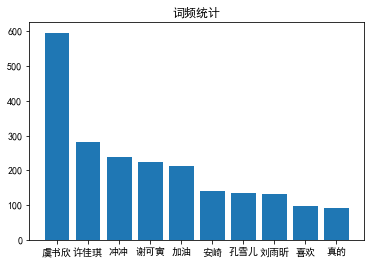

[2020-04-28 19:53:48,719] [    INFO] - Installing porn_detection_lstm module
[2020-04-28 19:53:48,786] [    INFO] - Module porn_detection_lstm already installed in /home/aistudio/.paddlehub/modules/porn_detection_lstm


陆柯燃林凡冲鸭加油啊大家看看这两个吧真的很好啊 0.7359
让我康下我昕姐的粉在哪里吖刘总真的太了好爱好爱色 0.7552
刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣啊啊啊啊妈妈爱你嗷嗷嗷嗷嗷么么哒亲亲亲亲亲亲亲亲加油喔 0.8556
喻言刘雨欣曾可妮谢可寅刘令姿许佳琪这几个比较适合色色 0.9986
我也喜欢虞书欣色色色 0.9947
虞书欣棒棒哒 0.6694
虞书欣是最好的一开始的评级并不算什么欣欣已经很努力了加油石榴们挺你色色色 0.9955
我怎么觉得没必要继续下去了直接出道吧这九人是最理想的了色色色 0.9974
许佳琪宝贝棒棒的加油我会永远支持你哒么么哒亲亲亲亲亲亲 0.8274
大家帮忙投一投许佳琪吧她真的是一个非常棒的姐姐虽然声乐不行但是她也说过自己会努力的她的舞蹈也是棒棒的她都掉排名了希望大家可以多多支持 0.9853
色色色 0.9998
色色色色色 0.9998
坤坤色色 0.902
坤学长好师啊啊啊啊啊啊啊啊啊色 0.5859
虞书欣赵小棠孔雪儿色色 0.971
欣欣子冲冲冲色色 0.8359
谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅谢可寅色色色色色色色色色色色色 0.9795
我要喻言高位出道色色色色 0.9993
赵小棠赵小棠虞书欣虞书欣色色色 0.9788


In [14]:
#评论是多分页的，得多次请求爱奇艺的评论接口才能获取多页评论,有些评论含有表情、特殊字符之类的
#num 是页数，一页10条评论，假如爬取1000条评论，设置num=100
if __name__ == "__main__":
    num = 101
    lastId = '0'
    counts = {}
    arr = []
    arr_clean = []
    arr_fenci = []
    test_text = []
    stopwords = stopwordslist('stopwords.txt')
    for i in range(num):
        lastId = saveMovieInfoToFile(lastId,arr)
        # time.sleep(0.5)
    for i in arr:
        arr_clean.append(clear_special_char(i))
    print("共抓到%d条评论"%(len(arr)))
    for i in arr_clean:
        arr_fenci.append(fenci(i))
    for i in arr_fenci:
        movestopwords(i,stopwords,counts)
    drawcounts(counts,10)
    text_detection(test_text,arr_clean)


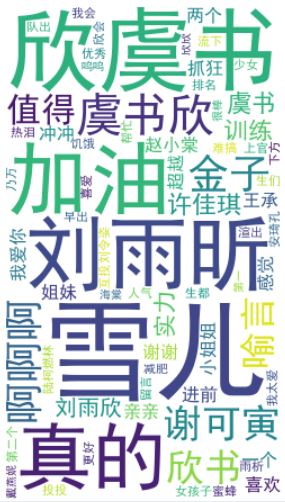

In [13]:
display(Image.open('WordsCloud.png')) #显示生成的词云图像